KNN可以说是最简单的机器学习算法，其思想非常的简单。

要对一个新的数据点做出预测，算法会在训练集中寻找与这个数据点距离最近的数据点，然后将找到的数据点的标签赋值给这个最新的数据点。

K最近邻中K的含义为，我们可以选择考虑训练集中与新数据点最近的任意K个邻居（例如可以观察3个或是5个），而不是只考虑最近的那一个。

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris

In [2]:
'''
官方文档：
    scikit-learn comes with a few small standard datasets that do not 
require to download any file from some external website.
'''

iris_dataset = load_iris()
# 观察到 load_iris 函数返回的是一个Bunch对象
type(iris_dataset)

sklearn.utils._bunch.Bunch

In [3]:
# 其与字典非常相似，包含了键值对
print("Keys of iris_dataset: \n{}".format(iris_dataset.keys()))

Keys of iris_dataset: 
dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


In [4]:
# 得到数据集和标签（numpy arr）
X, y = iris_dataset['data'], iris_dataset['target']

# 转换为pandas dataframe
X = pd.DataFrame(X, columns = iris_dataset['feature_names'])
y = pd.DataFrame(y, columns = ['Type'])

X

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


array([[<AxesSubplot:xlabel='sepal length (cm)', ylabel='sepal length (cm)'>,
        <AxesSubplot:xlabel='sepal width (cm)', ylabel='sepal length (cm)'>,
        <AxesSubplot:xlabel='petal length (cm)', ylabel='sepal length (cm)'>,
        <AxesSubplot:xlabel='petal width (cm)', ylabel='sepal length (cm)'>],
       [<AxesSubplot:xlabel='sepal length (cm)', ylabel='sepal width (cm)'>,
        <AxesSubplot:xlabel='sepal width (cm)', ylabel='sepal width (cm)'>,
        <AxesSubplot:xlabel='petal length (cm)', ylabel='sepal width (cm)'>,
        <AxesSubplot:xlabel='petal width (cm)', ylabel='sepal width (cm)'>],
       [<AxesSubplot:xlabel='sepal length (cm)', ylabel='petal length (cm)'>,
        <AxesSubplot:xlabel='sepal width (cm)', ylabel='petal length (cm)'>,
        <AxesSubplot:xlabel='petal length (cm)', ylabel='petal length (cm)'>,
        <AxesSubplot:xlabel='petal width (cm)', ylabel='petal length (cm)'>],
       [<AxesSubplot:xlabel='sepal length (cm)', ylabel='petal width (c

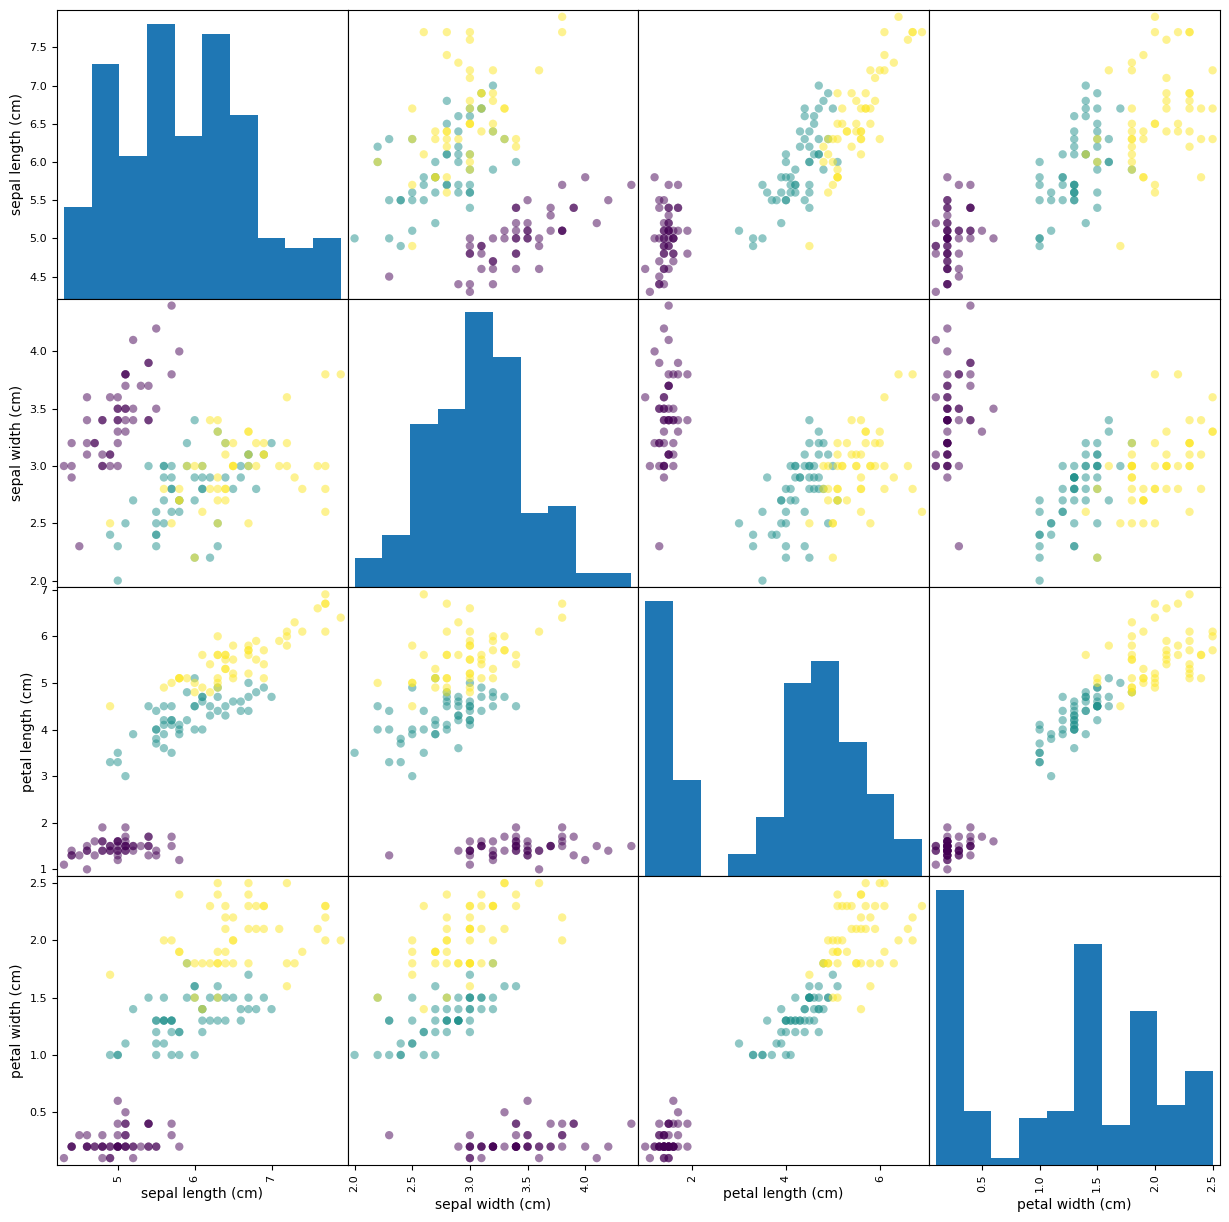

In [5]:
# 这里指定颜色的参数‘c'不接受dataframe，但可以接受np arr / pd series
pd.plotting.scatter_matrix(X, c = iris_dataset['target'], figsize = (15, 15), marker = 'o')

为了尝试KNN分类器的功能，观察到左下角的散点图，即使用'sepal length 萼片长度'和'petal width 花瓣宽度'可以比较容易的区分三种类别。尝试删除紫色的类别，然后对剩下的两种类别进行KNN二分类。

In [6]:
# 首先得到一整个dataframe
iris_df = X.join(y)

iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Type
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [7]:
# 然后删除所有的类别为2的行
iris_df = iris_df[iris_df['Type'] != 0]

# 再删除'sepal width' & 'petal length'列
iris_df = iris_df.drop(['sepal width (cm)', 'petal length (cm)'], axis = 1)

iris_df

,sepal length (cm),petal width (cm),Type
50,7.0,1.4,1
51,6.4,1.5,1
52,6.9,1.5,1
53,5.5,1.3,1
54,6.5,1.5,1
...,...,...,...
145,6.7,2.3,2
146,6.3,1.9,2
147,6.5,2.0,2
148,6.2,2.3,2


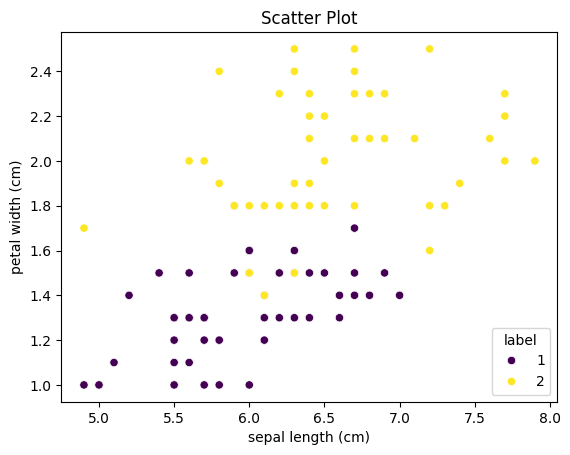

In [8]:
# 只观察关心的散点图
sns.scatterplot(x = iris_df['sepal length (cm)'], y = iris_df['petal width (cm)'], hue = iris_df['Type'], 
                palette = 'viridis', marker = 'o')

# 设置图形属性
plt.title('Scatter Plot')
# 增加图例
plt.legend(title = 'label', loc = 'lower right')
plt.show()

Test set accuracy is: 0.90


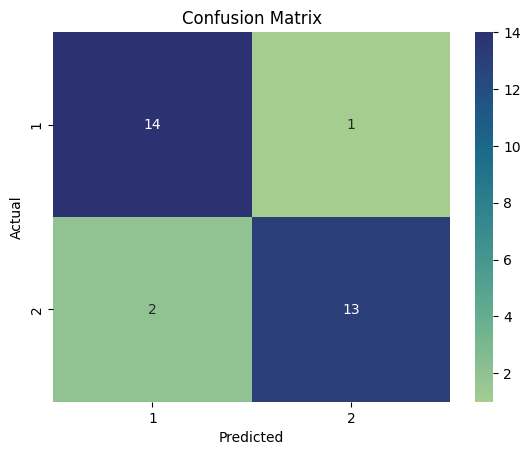

In [9]:
'''
训练KNN分类器模型
'''
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.neighbors import KNeighborsClassifier

# step0 得到X，所有的特征；和y，目标变量
X = iris_df.drop(['Type'], axis = 1)
y = iris_df['Type']

# step1 分离训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13, test_size = 0.3)

# step2 创建KNN分类器(此处为1-NN)
knn_clf = KNeighborsClassifier(n_neighbors = 1)

# step3 使分类器拟合训练集，KNN的拟合过程就只是把训练集保存起来
knn_clf.fit(X_train, y_train)

'''
评估KNN模型
'''
# step4 评估模型，计算其精确度
print('Test set accuracy is: {:.2f}'.format(knn_clf.score(X_test, y_test)))

# 查看一下混淆矩阵
y_pred = knn_clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred, labels = [1, 2])

# 使用seaborn绘制热力图
sns.heatmap(conf_matrix, annot = True, cmap="crest", xticklabels = [1, 2], yticklabels = [1, 2])

# 设置图形属性
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

c:\Users\MagicBoy Zhang\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


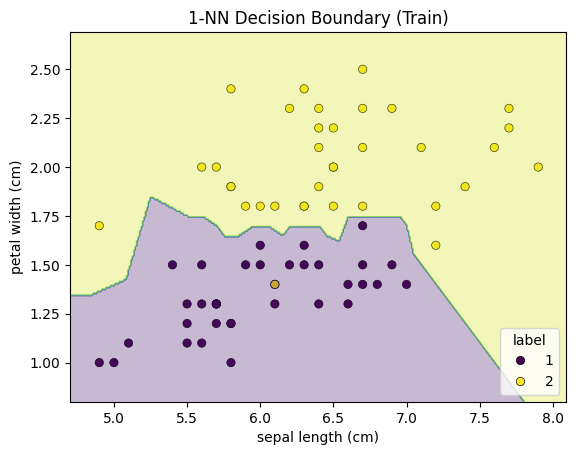

In [10]:
'''
绘制KNN决策边界
'''
# 得到x轴和y轴的范围
x_min, x_max = X_train['sepal length (cm)'].min() - 0.2, X_train['sepal length (cm)'].max() + 0.2
y_min, y_max = X_train['petal width (cm)'].min() - 0.2, X_train['petal width (cm)'].max() + 0.2

# 创建网格
#       np.meshgrid 用于生成二维坐标矩阵。np.arange 用于生成从 x_min 到 x_max，
#   以及从 y_min 到 y_max 的均匀间隔的值。xx 和 yy 分别是 x 轴和 y 轴上的坐标矩阵。
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# 预测决策边界
#       将网格中的坐标点展平为一维数组，通过 np.c_ 拼接为一个二维数组，然后使用 KNN 
#   模型 knn 进行预测，得到预测结果 Z。最后，通过 reshape 将一维数组转换为与网格形状相同的二维数组。
Z = knn_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 绘制数据点
sns.scatterplot(x = X_train['sepal length (cm)'], y = X_train['petal width (cm)'], hue = y_train, 
            palette = 'viridis', edgecolors = 'k', marker = 'o')

# 绘制决策边界
# 使用 contourf 函数绘制决策边界，通过填充等高线图的方式呈现分类区域。
plt.contourf(xx, yy, Z, alpha = 0.3, cmap = 'viridis')

# 设置标题和轴标签
plt.title('1-NN Decision Boundary (Train)')
plt.legend(title = 'label', loc = 'lower right')
plt.xlabel('sepal length (cm)')
plt.ylabel('petal width (cm)')

plt.show()

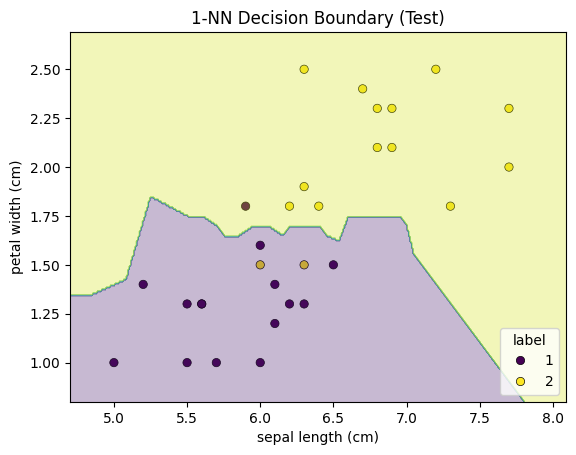

In [11]:
# 绘制数据点
sns.scatterplot(x = X_test['sepal length (cm)'], y = X_test['petal width (cm)'], hue = y_test, 
            palette = 'viridis', edgecolors = 'k', marker = 'o')

# 绘制决策边界
# 使用 contourf 函数绘制决策边界，通过填充等高线图的方式呈现分类区域。
plt.contourf(xx, yy, Z, alpha = 0.3, cmap = 'viridis')

# 设置标题和轴标签
plt.title('1-NN Decision Boundary (Test)')
plt.legend(title = 'label', loc = 'lower right')
plt.xlabel('sepal length (cm)')
plt.ylabel('petal width (cm)')

plt.show()

c:\Users\MagicBoy Zhang\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


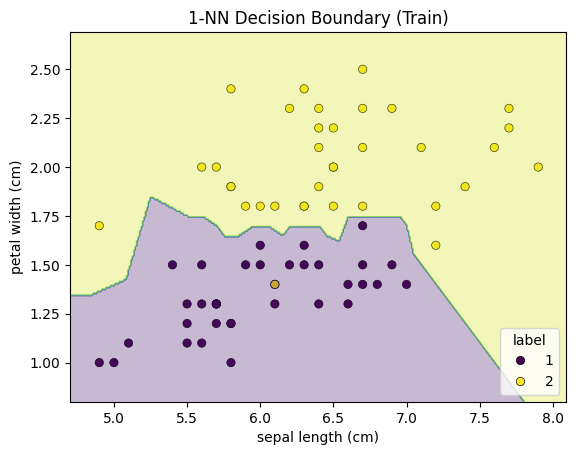

In [12]:
# 将绘制KNN决策边界的过程封装为函数

'''
此函数用于生成指定K的KNN决策边界图像

参数：
    X:      features set (can only has 2 features)
    y:      target
    k:      # of neighbors
    type:   string, can be 'train' or 'test', shown on the plot
'''
def plot_knn_decision_boundary(X, y, k, type):
    # 创建KNN分类器
    knn_clf = KNeighborsClassifier(n_neighbors = k)
    knn_clf.fit(X, y)
    
    # 得到x轴和y轴的范围
    x_min, x_max = X['sepal length (cm)'].min() - 0.2, X['sepal length (cm)'].max() + 0.2
    y_min, y_max = X['petal width (cm)'].min() - 0.2, X['petal width (cm)'].max() + 0.2

    # 创建网格
    #       np.meshgrid 用于生成二维坐标矩阵。np.arange 用于生成从 x_min 到 x_max，
    #   以及从 y_min 到 y_max 的均匀间隔的值。xx 和 yy 分别是 x 轴和 y 轴上的坐标矩阵。
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    # 预测决策边界
    #       将网格中的坐标点展平为一维数组，通过 np.c_ 拼接为一个二维数组，然后使用 KNN 
    #   模型 knn 进行预测，得到预测结果 Z。最后，通过 reshape 将一维数组转换为与网格形状相同的二维数组。
    Z = knn_clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # 绘制数据点
    sns.scatterplot(x = X['sepal length (cm)'], y = X['petal width (cm)'], hue = y, 
                palette = 'viridis', edgecolors = 'k', marker = 'o')

    # 绘制决策边界
    # 使用 contourf 函数绘制决策边界，通过填充等高线图的方式呈现分类区域。
    plt.contourf(xx, yy, Z, alpha = 0.3, cmap = 'viridis')

    # 设置标题和轴标签
    plt.title('{}-NN Decision Boundary ({})'.format(k, type))
    plt.legend(title = 'label', loc = 'lower right')
    plt.xlabel('sepal length (cm)')
    plt.ylabel('petal width (cm)')

    plt.show()

plot_knn_decision_boundary(X_train, y_train, 1, 'Train')

c:\Users\MagicBoy Zhang\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


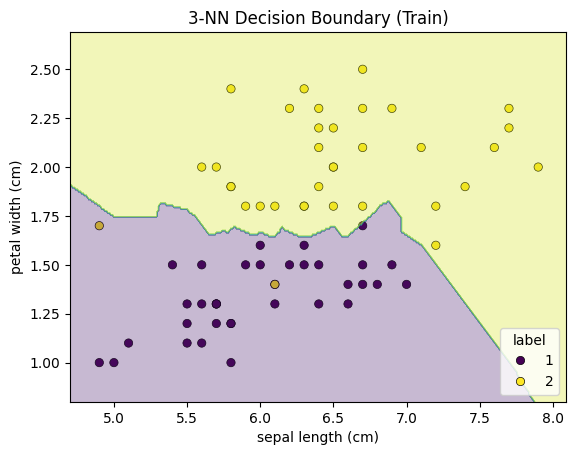

In [13]:
plot_knn_decision_boundary(X_train, y_train, 3, 'Train')

c:\Users\MagicBoy Zhang\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


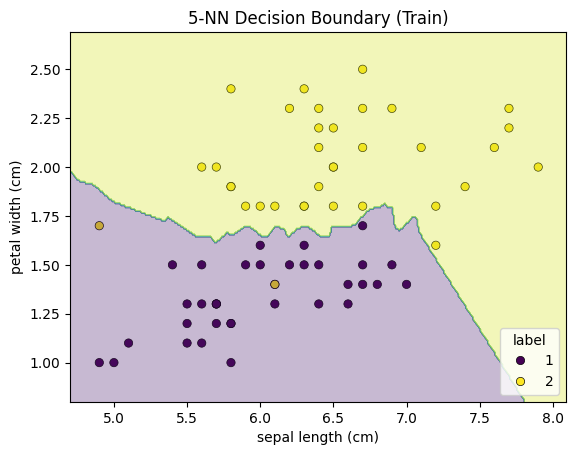

In [14]:
plot_knn_decision_boundary(X_train, y_train, 5, 'Train')